In [62]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [64]:
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 100
LOSS_FUNCTION = nn.MSELoss()
LOWEST_LOSS = float('inf')

In [65]:
y_loss = {}
y_loss['train'] = []
y_loss['test'] = []

X_epochs = []

In [66]:
def data_workflow(input_data, target_value):
    X = input_data.drop([target_value], axis=1)
    y = input_data[target_value]

    #print(X)
    #print(y)

    X = X.to_numpy()
    y = y.to_numpy()

    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    data = TensorDataset(X, y)

    train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=25)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

    print(f"training data: {train_dl}\n test data: {test_dl}")
    return train_dl, test_dl
    



In [67]:
csv_filepath = "./final_harvest_data.csv"

data = pd.read_csv(csv_filepath)
DATA = data.drop(['date', 'index', 'plant_id', 'tray_id', 'row', 'column'], axis=1)

DATA

,LFW_g,LDW_g,LA_mm2,length_mm,width_mm,height_mm,plant_area,plant_convex_hull_area,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path,plant_convex_hull_vertices,plant_ellipse_major_axis,plant_ellipse_minor_axis,plant_ellipse_angle,plant_ellipse_eccentricity
0,1.30,0.078,31.95,4.3,5.2,5.8,1211,1456.0,0.831731,189.923880,49,42,346,16,45.684494,40.965988,92.878510,0.442608
1,2.10,0.148,44.10,5.3,5.7,5.5,1412,1556.5,0.907164,181.338094,56,41,370,20,53.368065,37.484673,96.255425,0.711802
2,3.36,0.196,67.61,7.3,6.5,8.9,1303,1766.5,0.737617,247.865005,49,54,333,19,46.356819,43.059174,2.102176,0.370421
3,3.07,0.184,66.98,5.8,7.6,7.5,1601,1787.0,0.895915,203.480229,44,59,395,21,55.633369,38.548523,15.127802,0.721031
4,3.17,0.187,68.74,7.2,8.0,7.1,1919,2372.0,0.809022,263.421354,62,58,454,19,60.012882,48.875011,55.774792,0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,57.96,3.010,726.46,18.5,18.5,13.0,19084,22974.0,0.830678,767.938160,193,167,1367,33,190.580887,137.733093,62.138748,0.691160
161,81.46,3.880,1001.79,21.0,21.5,14.8,18373,21556.5,0.852318,661.612260,164,189,1317,29,176.040924,141.141724,22.056726,0.597653
162,140.84,6.380,1707.14,23.0,22.5,16.9,23374,26050.0,0.897274,683.754395,186,194,1427,31,191.379974,164.496170,175.959305,0.511091
163,108.17,5.250,1364.18,31.4,20.5,16.6,23457,25678.5,0.913488,671.754395,198,179,1364,31,194.815384,159.870819,122.656914,0.571464


In [68]:
LFW_train, LFW_test = data_workflow(DATA, 'LFW_g')

training data: <torch.utils.data.dataloader.DataLoader object at 0x7fae14ae2e20>
 test data: <torch.utils.data.dataloader.DataLoader object at 0x7fae00cf3d60>


In [69]:
def find_best_loss(current_best_val_loss, model_loss):
    if current_best_val_loss > model_loss:
        return model_loss
    else:
        return current_best_val_loss

In [70]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 1)
        ) 

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits.double()
        



In [71]:
model = DeepNeuralNetwork()
model = model.double()
print(model)

DeepNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=17, out_features=1, bias=True)
  )
)


In [72]:
def train_loop(dataset, model, loss_function, optimizer):
    model.train()
    for (X, y) in dataset:
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['train'].append(loss.item())
        

        loss.backward()
        optimizer.step()

        

        

In [73]:
def test_loop(dataset, model, loss_function, optimizer):
    
    for (X, y) in dataset:
        y = y.view(-1,1) 
        
        model.zero_grad()
        optimizer.zero_grad()

        prediction = model(X)
        loss = loss_function(prediction, y)

        y_loss['test'].append(loss.item())

 

        loss.backward()
        optimizer.step()

        
        print(f"Test Loss: {loss}")
        

In [74]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n------------------------------------")
    train_loop(LFW_train, model, LOSS_FUNCTION, optimizer)
    test_loop(LFW_test, model, LOSS_FUNCTION, optimizer)
    X_epochs.append(t)
print("Training complete!")

Epoch 1
------------------------------------
Test Loss: 3000007.4021008275
Test Loss: 2636501.964688849
Test Loss: 2103854.906253908
Test Loss: 544596.2335847632
Test Loss: 111434.26685771275
Epoch 2
------------------------------------
Test Loss: 602574.0015320748
Test Loss: 700102.6277154796
Test Loss: 664393.415941099
Test Loss: 958865.6355950942
Test Loss: 5560.957070193515
Epoch 3
------------------------------------
Test Loss: 128565.53857442053
Test Loss: 241121.7227945436
Test Loss: 187461.11454225538
Test Loss: 225334.45113960118
Test Loss: 301.43662947636875
Epoch 4
------------------------------------
Test Loss: 33672.65240224591
Test Loss: 2493.598080207301
Test Loss: 14604.423706892707
Test Loss: 98061.61191795522
Test Loss: 60339.67055530061
Epoch 5
------------------------------------
Test Loss: 13315.225106490501
Test Loss: 17539.18444670196
Test Loss: 3611.23369289822
Test Loss: 30798.05093779324
Test Loss: 580.3597044336149
Epoch 6
------------------------------------

[2356075.321387065, 15834219.871476823, 15755826.064962527, 2459443.748579268, 3862510.712525664, 2174288.639004457, 1976118.5168935733, 4925423.598973546, 3564896.999664903, 4778128.504077399, 3426915.613331068, 3125636.411854569, 893673.9548963413, 1404432.244147128, 1645999.2165546168, 1689331.479280841, 2563091.051143471, 1819701.1939063813, 1456028.4660789836, 1998292.2203792073, 1319983.2015254789, 806521.1929106065, 1728207.7657061766, 2119057.5685336683, 1660803.9188933368, 1209109.7003371757, 12164691.797761718, 1263270.4492166196, 684061.6022722621, 794894.5474483969, 233161.35013173538, 930896.4131594652, 740540.7538615819, 528129.0699409005, 361953.6220707565, 463168.08511730225, 628247.2207841116, 124120.92559599204, 3801462.9058988974, 467732.82011649385, 342723.84444525815, 662872.2355353639, 574444.2167772731, 244661.40465733162, 242447.97097214902, 2817971.8055330827, 320723.63890327775, 101820.31497063173, 368713.701693127, 241047.31159726874, 246931.14143031617, 1057

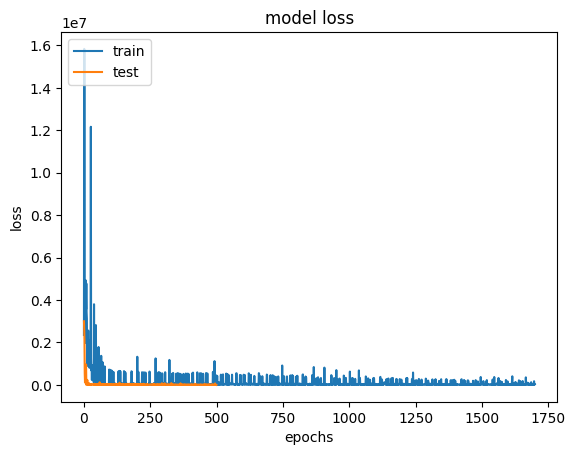

In [75]:
print(y_loss['train'])
plt.plot(y_loss['train'])
plt.plot(y_loss['test'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()